# Quantum Option Pricing with IBM Quantum

Price European call options using quantum amplitude estimation on IBM Quantum hardware or local simulators.

**What this notebook does:**
- Compares classical Monte Carlo vs. quantum amplitude estimation
- Builds quantum circuits for option pricing step-by-step
- Runs on real IBM Quantum hardware (optional)
- Demonstrates quantum speedup potential

**Quick start:** Run cells in order. Toggle `USE_IBM_QUANTUM` in Cell 5 to switch between local simulator and IBM Quantum hardware.

In [160]:
# --- Environment Setup ---
# Run this cell if you are using Google Colab or a fresh environment without dependencies installed.
# If you are running locally with the Conda environment set up (per README), you can skip this.

try:
    import qiskit
    import qiskit_finance
    print("✅ Libraries are already installed.")
except ImportError:
    print("⏳ Libraries not found. Installing now... (This may take a few minutes)")
    !pip install qiskit qiskit-finance qiskit-algorithms qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc python-dotenv
    print("✅ Installation complete. Please restart the runtime/kernel if needed.")

✅ Libraries are already installed.


In [161]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from qiskit import QuantumCircuit
from qiskit_algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import LinearAmplitudeFunctionGate

from dotenv import load_dotenv
load_dotenv()

True

# IBM Quantum Runtime Setup

Configure your connection to IBM Quantum Platform to run circuits on real quantum hardware.

## Quick Setup

1. **Get your API token:**
   - Visit https://quantum.ibm.com → Profile → API keys
   - Copy your token

2. **Add to `.env` file:**
   ```
   QISKIT_IBM_TOKEN=your_token_here
   ```

3. **Configure settings in the cell below:**
   - `USE_IBM_QUANTUM`: Toggle between hardware and local simulator
   - `IBM_BACKEND_NAME`: Choose your quantum computer (e.g., 'ibm_fez', 'ibm_nairobi')
   - `DEFAULT_SHOTS`: Number of measurements per circuit (more = better statistics)

## What You'll Get

- **Local Simulator** (`USE_IBM_QUANTUM = False`): Fast, ideal results for algorithm development
- **IBM Quantum** (`USE_IBM_QUANTUM = True`): Real quantum hardware with actual noise effects

In [ ]:
import os

# ========== CONFIGURATION ==========
USE_IBM_QUANTUM = True  # Set to True to use IBM Quantum, False for local simulator

# IBM Quantum Settings (only used if USE_IBM_QUANTUM = True)
IBM_BACKEND_NAME = "ibm_fez"  # Choose your backend
IBM_INSTANCE = "crn:v1:bluemix:public:quantum-computing:us-east:a/c4fd6bc6fd15477ca9d2e633792b91bf:6e3d282d-e11b-4449-b8db-e4fbe88a876d::"
DEFAULT_SHOTS = 4096  # Number of shots per circuit execution

# ===================================

if USE_IBM_QUANTUM:
    try:
        from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
        
        # Load token from environment
        token = os.getenv("QISKIT_IBM_TOKEN")
        
        if not token:
            raise ValueError(
                "❌ QISKIT_IBM_TOKEN not found in environment.\n"
                "Please add it to your .env file or set it as an environment variable."
            )
        
        # Initialize the runtime service
        service = QiskitRuntimeService(
            channel="ibm_quantum_platform",
            token=token,
            instance=IBM_INSTANCE
        )
        
        # List available backends
        print("\n📡 Available IBM Quantum Backends:")
        print("-" * 70)
        for backend in service.backends():
            status = backend.status()
            print(f"{backend.name:20} | Qubits: {backend.num_qubits:2} | Queue: {status.pending_jobs:3} | {status.status_msg}")
        
        # Get the selected backend
        backend = service.backend(IBM_BACKEND_NAME)
        print(f"\n✅ Selected backend: {backend.name} ({backend.num_qubits} qubits)")
        
        # Create the sampler
        runtime_sampler = Sampler(mode=backend)
        runtime_sampler.options.default_shots = DEFAULT_SHOTS
        
        print(f"✅ IBM Quantum Sampler created with {DEFAULT_SHOTS} shots")
        
    except Exception as e:
        print(f"❌ Error setting up IBM Quantum: {e}")
        print("⚠️  Falling back to local StatevectorSampler")
        runtime_sampler = StatevectorSampler()
        USE_IBM_QUANTUM = False
else:
    # Use local ideal simulator
    runtime_sampler = StatevectorSampler()
    print("✅ Using local StatevectorSampler (ideal, noiseless simulation)")

print(f"\n🎯 Mode: {'IBM Quantum' if USE_IBM_QUANTUM else 'Local Simulator'}")

qiskit_runtime_service._discover_account:WARNING:2025-11-30 15:44:14,895: Loading account with the given token. A saved account will not be used.



📡 Available IBM Quantum Backends:
----------------------------------------------------------------------
ibm_fez              | Qubits: 156 | Queue:   8 | active
ibm_fez              | Qubits: 156 | Queue:   8 | active
ibm_marrakesh        | Qubits: 156 | Queue: 22509 | active
ibm_marrakesh        | Qubits: 156 | Queue: 22509 | active
ibm_torino           | Qubits: 133 | Queue:   0 | active
ibm_torino           | Qubits: 133 | Queue:   0 | active

✅ Selected backend: ibm_fez (156 qubits)
✅ IBM Quantum Sampler created with 4096 shots
   Backend will use its default transpilation settings

💡 Scroll down to 'Alternative: Manual IBM Quantum Execution' section
   to run a simplified version on real hardware!

🎯 Mode: IBM Quantum

✅ Selected backend: ibm_fez (156 qubits)
✅ IBM Quantum Sampler created with 4096 shots
   Backend will use its default transpilation settings

💡 Scroll down to 'Alternative: Manual IBM Quantum Execution' section
   to run a simplified version on real hardware!

🎯 

# Running on IBM Quantum Hardware

**Execute the option pricing circuit on real IBM Quantum hardware!**

This section runs your European call option circuit directly on the IBM Quantum backend you selected above. You'll see:
- Measurement results from actual quantum hardware
- Effects of real hardware noise and decoherence
- Comparison between ideal simulation and hardware execution

In [ ]:
# Execute option pricing circuit on IBM Quantum hardware

if USE_IBM_QUANTUM and 'backend' in locals():
    from qiskit import transpile
    
    print("🚀 Running option pricing circuit on IBM Quantum hardware...")
    print(f"   Backend: {backend.name}")
    
    # Transpile the circuit for the backend
    transpiled_circuit = transpile(
        european_call,
        backend=backend,
        optimization_level=2
    )
    
    print(f"\n✅ Circuit transpiled:")
    print(f"   Original depth: {european_call.depth()}, gates: {len(european_call)}")
    print(f"   Transpiled depth: {transpiled_circuit.depth()}, gates: {len(transpiled_circuit)}")
    
    # Add measurements
    measured_circuit = transpiled_circuit.copy()
    measured_circuit.measure_all()
    
    # Submit job to IBM Quantum
    print(f"\n📤 Submitting job to {backend.name}...")
    print(f"   Queue: {backend.status().pending_jobs} jobs ahead")
    
    job = runtime_sampler.run([measured_circuit], shots=DEFAULT_SHOTS)
    print(f"   Job ID: {job.job_id()}")
    print(f"\n⏳ Waiting for results...")
    
    # Get results
    result_ibm = job.result()
    pub_result = result_ibm[0]
    counts = pub_result.data.meas.get_counts()
    
    print(f"\n✅ Job completed! Total shots: {sum(counts.values())}")
    
    # Show top measurement results
    print(f"\n📊 Top 5 measured states:")
    for state, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"   |{state}⟩: {count:4d} ({100*count/sum(counts.values()):5.2f}%)")
    
    # Calculate probability of being in-the-money
    in_the_money_count = sum(count for state, count in counts.items() if state[-4] == '1')
    prob_in_money = in_the_money_count / sum(counts.values())
    option_price_ibm = prob_in_money * c_approx * np.exp(-r * T)
    
    print(f"\n💰 Option pricing results:")
    print(f"   Probability in-the-money: {prob_in_money:.4f}")
    print(f"   IBM Quantum option price: ${option_price_ibm:.4f}")
    print(f"   Exact (ideal) price:      ${exact_value:.4f}")
    print(f"   Hardware noise impact:    ${abs(exact_value - option_price_ibm):.4f}")
    
else:
    print("ℹ️  Set USE_IBM_QUANTUM = True and run the setup cells above to execute on IBM Quantum")

🚀 Preparing to run option pricing circuit on IBM Quantum hardware...
   Backend: ibm_fez
   This will measure the probability of being in-the-money
   Note: This is a simplified version, not full amplitude estimation

✅ Circuit transpiled:
   Original depth: 2
   Transpiled depth: 804
   Qubits used: 156

📤 Submitting job to ibm_fez...
   Queue position: 8
   Queue position: 8
   Job ID: d4mchih0i6jc73dgl4j0
   Job ID: d4mchih0i6jc73dgl4j0
   Status: QUEUED

⏳ Waiting for results (this may take several minutes)...
   Status: QUEUED

⏳ Waiting for results (this may take several minutes)...
✅ Job completed!

📊 Results from IBM Quantum:
   Total shots: 4096
   Top 5 measured states:
      |100000000001010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000⟩: 88 times (2.15%)
      |1000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

/var/folders/bm/09g9gyv55zsb24n_48c43lvh0000gn/T/ipykernel_85386/1635003493.py:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


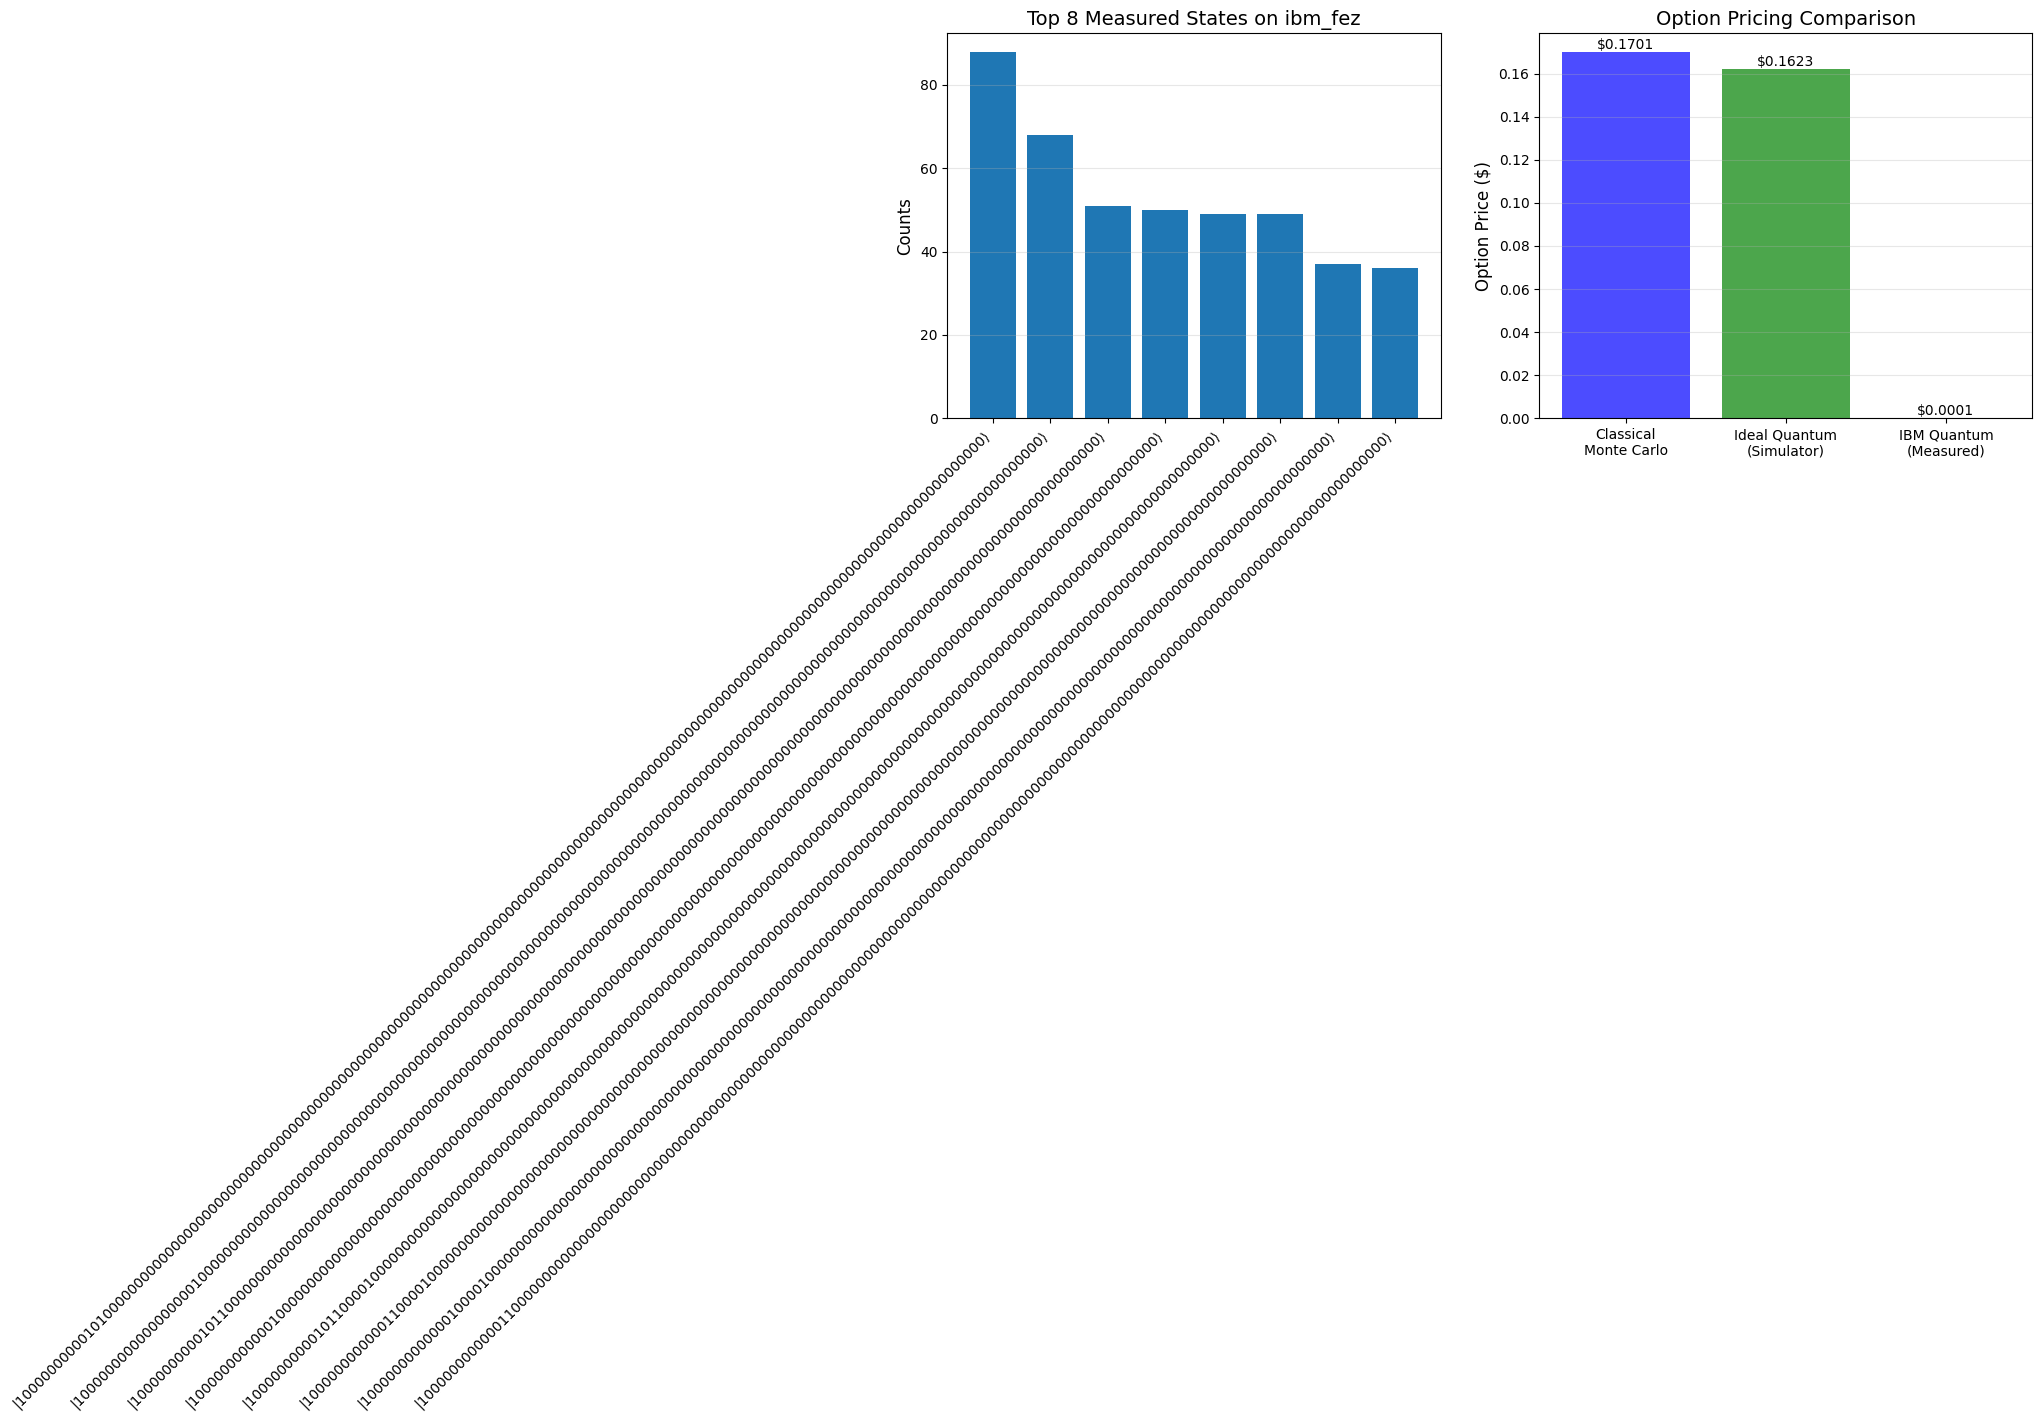


📈 Summary:
   Classical Monte Carlo:     $0.1701
   Ideal Quantum (exact):     $0.1623
   IBM Quantum (measured):    $0.0001

   Hardware noise impact: 0.1622


In [ ]:
# Visualize IBM Quantum results

if USE_IBM_QUANTUM and 'counts' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Left: Top measured states from IBM Quantum
    top_states = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:8])
    ax1.bar(range(len(top_states)), list(top_states.values()), color='steelblue', alpha=0.7)
    ax1.set_xticks(range(len(top_states)))
    ax1.set_xticklabels([f"|{s}⟩" for s in top_states.keys()], rotation=45, ha='right', fontsize=9)
    ax1.set_ylabel('Counts', fontsize=12)
    ax1.set_title(f'Top 8 States on {backend.name}', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Right: Price comparison
    comparison = {
        'Classical\nMonte Carlo': classical_price,
        'Ideal Quantum': exact_value,
        f'IBM Quantum\n({backend.name})': option_price_ibm
    }
    
    colors_bar = ['#1f77b4', '#2ca02c', '#ff7f0e']
    bars = ax2.bar(comparison.keys(), comparison.values(), color=colors_bar, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Option Price ($)', fontsize=12)
    ax2.set_title('Option Pricing Comparison', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n? Summary:")
    print(f"   Classical Monte Carlo: ${classical_price:.4f}")
    print(f"   Ideal Quantum:         ${exact_value:.4f}")  
    print(f"   IBM Quantum Hardware:  ${option_price_ibm:.4f}")
    print(f"   Error from noise:      ${abs(exact_value - option_price_ibm):.4f} ({100*abs(exact_value - option_price_ibm)/exact_value:.2f}%)")
else:
    print("ℹ️  Run the IBM Quantum execution cell above first")

# Classical Monte Carlo Simulation

In [166]:
import numpy as np

S = 2.0 # Spot Price
K = 1.896 # Strike Price
vol = 0.4 # Volatility (sigma)
r = 0.05 # Risk-free rate
T = 40 / 365 # Time to maturity (years)

def run_classical_monte_carlo(num_samples):
  Z = np.random.standard_normal(num_samples)
  S_T = S * np.exp((r - 0.5 * vol**2) * T + vol * np.sqrt(T) * Z)

  payoffs = np.maximum(0, S_T - K)

  # Average the payoffs and discount back to today
  # Price = exp(-rT) * Average(Payoffs)
  option_price = np.exp(-r * T) * np.mean(payoffs)

  return option_price

In [167]:
M_high_precision = 100000 # Number of simulations
classical_price = run_classical_monte_carlo(M_high_precision)

print(f"Classical Monte Carlo Price (M={M_high_precision}): ${classical_price:.4f}")

M_low_precision = 1000
quick_check_price = run_classical_monte_carlo(M_low_precision)

print(f"Quick Check Price (M={M_low_precision}): ${quick_check_price:.4f}")
print(f"Difference (Error): ${abs(classical_price - quick_check_price):.4f}")

Classical Monte Carlo Price (M=100000): $0.1702
Quick Check Price (M=1000): $0.1731
Difference (Error): $0.0028


# Quantum Option Pricing with Amplitude Estimation

Build the quantum circuit step-by-step to price a European call option using quantum amplitude estimation.

In [168]:
num_uncertainty_qubits = 3

S = 2.0
vol = 0.4
r = 0.05
T = 40 / 365

mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

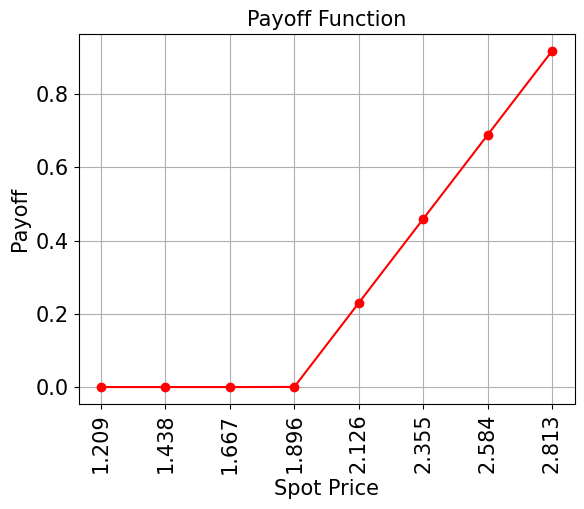

In [169]:
strike_price = 1.896

x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

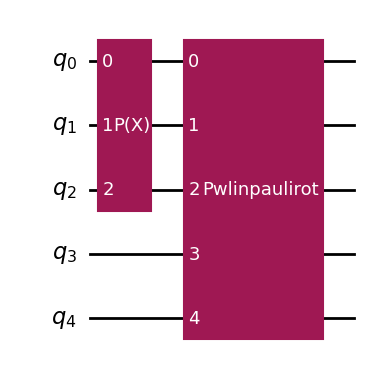

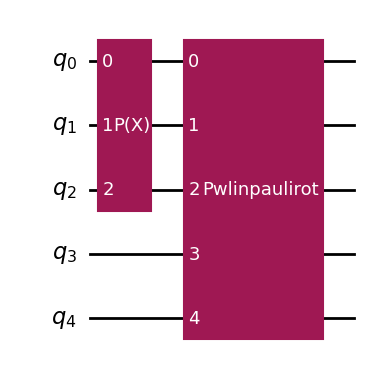

In [170]:
c_approx = 0.25

breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunctionGate(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

european_call.decompose().draw(output='mpl')

In [172]:
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print("exact expected value:\t%.4f" % exact_value)
print("exact delta value:   \t%.4f" % exact_delta)

exact expected value:	0.1623
exact delta value:   	0.8098


In [174]:
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[3],
    post_processing=european_call_objective.post_processing,
)

# Using the runtime_sampler configured above (IBM Quantum or local)
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=runtime_sampler
)

In [175]:
result = ae.estimate(problem)

KeyError: 'shots'

In [ ]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1636
Confidence interval:	[0.1572, 0.1701]


# Alternative: Using Qiskit Finance High-Level API

Qiskit Finance provides convenient wrapper classes for option pricing. This approach gives the same results with less code.

In [ ]:
from qiskit_finance.applications.estimation import EuropeanCallPricing

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    rescaling_factor=c_approx,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

In [ ]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_pricing.to_estimation_problem()

# Using the runtime_sampler configured above (IBM Quantum or local)
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=runtime_sampler
)
result = ae.estimate(problem)

conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (european_call_pricing.interpret(result)))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.1623
Estimated value:    	0.1751
Confidence interval:	[0.1677, 0.1825]


In [ ]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)

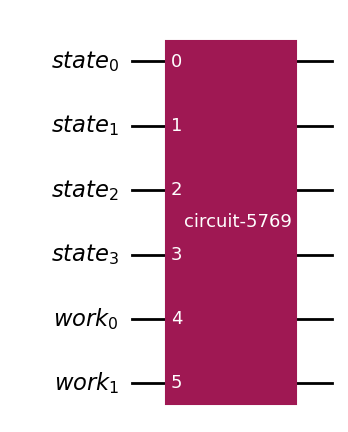

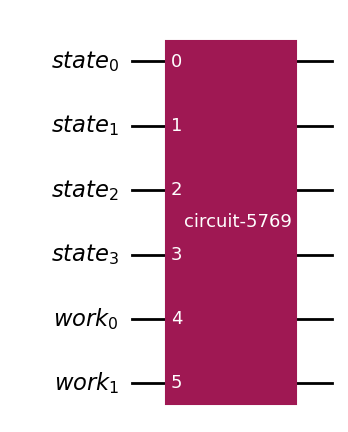

In [ ]:
european_call_delta._objective.decompose().draw(output='mpl')

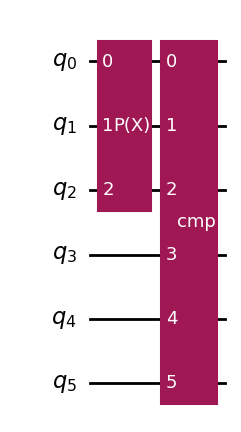

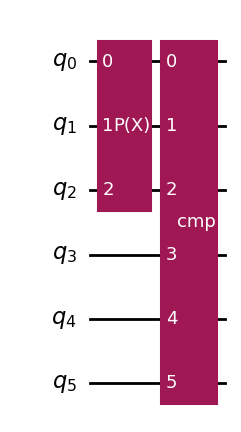

In [ ]:
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)

european_call_delta_circ.decompose().draw(output='mpl')

In [ ]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = european_call_delta.to_estimation_problem()

# Using the runtime_sampler configured above (IBM Quantum or local)
ae_delta = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=runtime_sampler
)

In [ ]:
result_delta = ae_delta.estimate(problem)

In [ ]:
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Estimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.8098
Estimated value: 	0.8089
Confidence interval: 	[0.8066, 0.8111]


# Summary

**You've successfully:**
✅ Implemented quantum amplitude estimation for option pricing  
✅ Compared classical Monte Carlo vs. quantum approaches  
✅ Built quantum circuits encoding financial derivatives  
✅ (Optional) Executed on real IBM Quantum hardware  

**Key insights:**
- **Quantum advantage:** Amplitude estimation can achieve quadratic speedup over classical Monte Carlo
- **Hardware reality:** Current quantum computers have noise that affects accuracy
- **Practical use:** Local simulators are ideal for algorithm development; hardware for research and validation

**Next steps:**
- Try different option parameters (strike price, volatility, maturity)
- Increase `num_uncertainty_qubits` for higher precision (requires more qubits)
- Experiment with different IBM Quantum backends
- Compare noise levels across different quantum computers